# Thematic differences

DHH23 Parliament group

Author: Pontus H.

In [101]:
# Set the theme here
THEME = 'eu_SI'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [102]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [103]:
# Optional stopwords
with open('../data/stopwords-si.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [104]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [105]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u40,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SMC,Stranka modernega centra,Coalition,"Matić, Dragan",M,1964,Hvala za besedo. Spoštovani predsednik Vlade! ...,Spoštovani predsednik Vlade! Slovenija je v z...,0.675293,2332
1,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u182,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Logar, Anže",M,1976,"Hvala, predsedujoči. Kadarkoli je na dnevnem r...",Kadarkoli je na dnevnem redu upravljanje z dr...,-0.850586,1973
2,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u186,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Logar, Anže",M,1976,"Hvala. Samo potem mi ministrica ni odgovorila,...","Samo potem mi ministrica ni odgovorila, glede...",-0.531250,1497
3,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u190,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Logar, Anže",M,1976,"Hvala, predsedujoči. To pa ne bo držalo, kar j...","To pa ne bo držalo, kar je ministrica na konc...",-0.724609,1571
4,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u192,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,Levica,Levica,Opposition,"Tomić, Violeta",F,1963,"Hvala za besedo, predsedujoči. Kolegice in kol...",Kolegice in kolegi! Izgradnja belokranjskega ...,-0.905273,1791


In [106]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [107]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.1)

In [108]:
pd.Series(new_topics).value_counts()

 0     1375
 1      697
 2      518
 3      492
 7      455
 5      396
 4      367
 6      317
 10     256
 14     254
 12     252
 17     251
 11     242
 9      210
 8      208
 15     205
 16     186
 21     145
 18     139
 20     136
-1      130
 13     130
 19     126
 25     122
 23     102
 27      97
 22      96
 24      92
 26      78
 29      75
 28      69
 30      63
 31      63
 32      58
dtype: int64

In [109]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [110]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [111]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 34
Number of topics before: 34


In [112]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     2714
 18     916
 26     458
 8      445
 13     345
 3      334
 25     313
 31     224
 29     202
 2      187
 24     177
 16     176
 12     154
 28     131
 6      112
 7      110
 27     109
 30     109
 17     108
 15     106
 10      98
 23      92
 32      85
 0       81
 4       81
 22      68
 21      64
 19      63
 20      62
 14      59
 1       57
 9       56
 5       53
 11      53
dtype: int64

In [113]:
topic_model.visualize_topics()

Topics over time

In [114]:
# Reference running time for this cell: 2min 30s
topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [115]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [116]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [117]:
# Brexit
topics_over_time[topics_over_time['Topic'] == 0]

,Topic,Words,Frequency,Timestamp,Name
1,0,"tem, bom, neko, stvari, sedaj",21,2000-11-08 04:32:09.600,0_sem_potem_tem_samo
23,0,"bleda, lokacijskega, hidroelektrarne, revizijs...",19,2001-12-11 13:12:00.000,0_sem_potem_tem_samo
49,0,"romske, mladoletnikov, sod, seveda, zobozdravnik",22,2003-01-06 02:24:00.000,0_sem_potem_tem_samo
75,0,"seveda, ko, tem, potem, samo",41,2004-01-31 15:36:00.000,0_sem_potem_tem_samo
105,0,"dobičku, zaposlenih, zakon, ta, tablicah",39,2005-02-25 04:48:00.000,0_sem_potem_tem_samo
132,0,"minister, koncesij, bil, tukaj, ta",62,2006-03-22 18:00:00.000,0_sem_potem_tem_samo
163,0,"pokrajine, potem, samo, gospod, seveda",47,2007-04-17 07:12:00.000,0_sem_potem_tem_samo
195,0,"danes, zelo, tem, leta, so",40,2008-05-11 20:24:00.000,0_sem_potem_tem_samo
223,0,"ta, način, bil, mislim, predsednik",44,2009-06-06 09:36:00.000,0_sem_potem_tem_samo
256,0,"zakon, potem, samo, zelo, vlade",46,2010-07-01 22:48:00.000,0_sem_potem_tem_samo


In [118]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

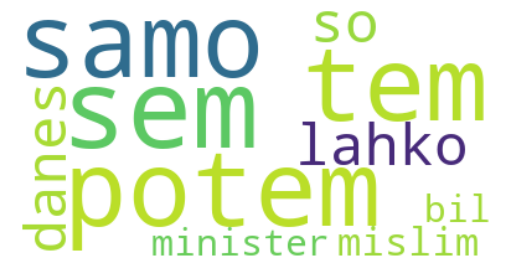

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [120]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [121]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['sem',
 'potem',
 'tem',
 'samo',
 'lahko',
 'so',
 'danes',
 'mislim',
 'minister',
 'bil']

In [122]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
speech_topic_party.loc[speech_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
speech_topic_party.loc[speech_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

TypeError: bad operand type for unary ~: 'float'

In [ ]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,CON,LAB,LAB;I,OTHER,SNP
topic,,,,,
0,23.5,22.1,55.6,29.6,28.9
1,14.3,12.0,11.1,17.8,14.7
2,15.6,12.7,0.0,11.2,13.4
3,9.0,12.0,0.0,3.8,3.7
4,8.2,6.5,0.0,5.6,7.2
5,6.6,6.5,0.0,7.4,5.1
6,6.2,8.8,22.2,5.6,11.0
7,5.4,4.2,0.0,6.8,2.9
8,5.2,8.9,11.1,6.8,9.6


In [ ]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,CON,LAB,LAB;I,OTHER,SNP,keywords
topic,,,,,,
0,23.5,22.1,55.6,29.6,28.9,"[action, chilcot, chemical, airstrikes, prime,..."
1,14.3,12.0,11.1,17.8,14.7,"[veterans, aged, covenant, royal, somme, 1st, ..."
2,15.6,12.7,0.0,11.2,13.4,"[invasion, aggression, crimea, president, krem..."
3,9.0,12.0,0.0,3.8,3.7,"[officers, prisons, frontline, cuts, youth, an..."
4,8.2,6.5,0.0,5.6,7.2,"[ajax, review, security, space, programme, exp..."
5,6.6,6.5,0.0,7.4,5.1,"[read, presentation, 57, printed, constituency..."
6,6.2,8.8,22.2,5.6,11.0,"[yemen, arms, ceasefire, sales, hodeidah, clus..."
7,5.4,4.2,0.0,6.8,2.9,"[rwanda, trade, amendment, yazidi, human, arme..."
8,5.2,8.9,11.1,6.8,9.6,"[chancellor, universal, billion, income, growt..."


In [ ]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,CON,LAB,LAB;I,OTHER,SNP
0,0,57.8,25.5,0.3,5.8,10.6
1,1,60.6,23.9,0.1,6.1,9.3
2,2,63.7,24.5,0.0,3.7,8.2
3,3,57.9,36.6,0.0,2.0,3.5
4,4,64.2,23.9,0.0,3.5,8.4
5,5,59.9,27.8,0.0,5.4,6.9
6,6,49.9,33.0,0.4,3.6,13.1
7,7,64.4,23.9,0.0,6.6,5.1
8,8,45.6,36.8,0.2,4.8,12.6
9,9,61.2,29.4,0.0,4.2,5.1


Calculate mean sentiment for each topic per party

In [ ]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,CON,LAB,LAB;I,OTHER,SNP
topic,,,,,
0,-0.103555,-0.288387,-0.453979,-0.297226,-0.369158
1,0.249124,0.094287,-0.561523,0.131890,0.007525
2,-0.134097,-0.317031,0.000000,-0.300507,-0.231586
3,0.166552,-0.388674,0.000000,0.067167,-0.191340
4,0.144165,-0.198772,0.000000,-0.283788,-0.142760
5,0.416654,0.289754,0.000000,0.271197,0.337006
6,-0.055156,-0.310781,-0.318909,-0.239646,-0.400558
7,-0.104778,-0.244251,0.000000,0.079727,-0.133543
8,0.119953,-0.356855,-0.918945,-0.201761,-0.279451
